# Capstone project 1: Pet Product Auto-Subcategorization by Review Analysis (preprocessing)

**Goal: Creating a system that automatically classifies products in Pet Supplies category into subcategories by analyzing the reviews.**  
In this project, the data collected during 2014 - 2015 in the US is used.

## 1. Loading Data

In [1]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import csv

sns.set(context='notebook', style='ticks', palette='hls')

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle the code on/off."></form>''')

The dataset is available on https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Pet_Products_v1_00.tsv.gz

In [3]:
# Load the tsv file with columns which will be used
data = pd.read_table('amazon_reviews_us_Pet_Products_v1_00.tsv', usecols=[0,4,5,6,13,14])
data.head()

,marketplace,product_parent,product_title,product_category,review_body,review_date
0,US,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Pet Products,Best belly bands on the market! These are a g...,2015-08-31
1,US,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,Pet Products,"My dogs love Hugs and Kisses. However, the la...",2015-08-31
2,US,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,Pet Products,I have been purchasing these for a long time. ...,2015-08-31
3,US,568880110,"Soft Side Pet Crate, Navy/Tan",Pet Products,"It is extremely well constructed, it is easy t...",2015-08-31
4,US,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Pet Products,Worked really well. Very pleased with my purc...,2015-08-31


In [4]:
# Change the clomun label from 'product_parent' to 'product_id'
data = data.rename(columns={'product_parent':'product_id'})
data.head()

,marketplace,product_id,product_title,product_category,review_body,review_date
0,US,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Pet Products,Best belly bands on the market! These are a g...,2015-08-31
1,US,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,Pet Products,"My dogs love Hugs and Kisses. However, the la...",2015-08-31
2,US,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,Pet Products,I have been purchasing these for a long time. ...,2015-08-31
3,US,568880110,"Soft Side Pet Crate, Navy/Tan",Pet Products,"It is extremely well constructed, it is easy t...",2015-08-31
4,US,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Pet Products,Worked really well. Very pleased with my purc...,2015-08-31


In [5]:
# Check the general information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2639981 entries, 0 to 2639980
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   marketplace       object
 1   product_id        int64 
 2   product_title     object
 3   product_category  object
 4   review_body       object
 5   review_date       object
dtypes: int64(1), object(5)
memory usage: 120.8+ MB


In [6]:
# Is there any missing date?: Yes
data.isnull().any(axis=0)

marketplace         False
product_id          False
product_title        True
product_category    False
review_body          True
review_date          True
dtype: bool

## 2. Data Cleaning and Wrangling

#### Approach:

2.1. Extracting data collected in 2014 or 2015  
2.2. Removing columns having a single value  
2.3. Dealing with missing values and duplicate data  
2.4. Removing short and long reviews  
2.5. Removing products having only one review  
2.6. Adjusting the number of reviews per product  
2.7. Merging reviews to the same product in one  
2.8. Tokenization  
2.9. Retaining only alphabets  
2.10. Removing stop words  
2.11. Stemming and lemmatization  
2.12. Retaining only nouns  
2.13. Removing words appearing 4 times or less  
2.14. Removing products having 4 tokens or less

### 2.1. Extracting data collected in 2014 or 2015

In [7]:
# Extract data in 2015 (ignore data without a date label)
df_2015 = data[data['review_date'].str.contains('2015-', na=False)] 
df_2015.head()

,marketplace,product_id,product_title,product_category,review_body,review_date
0,US,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Pet Products,Best belly bands on the market! These are a g...,2015-08-31
1,US,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,Pet Products,"My dogs love Hugs and Kisses. However, the la...",2015-08-31
2,US,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,Pet Products,I have been purchasing these for a long time. ...,2015-08-31
3,US,568880110,"Soft Side Pet Crate, Navy/Tan",Pet Products,"It is extremely well constructed, it is easy t...",2015-08-31
4,US,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Pet Products,Worked really well. Very pleased with my purc...,2015-08-31


In [8]:
# Check the number of the rows
len(df_2015)

875524

In [9]:
# Extract data in 2014 (ignore data without a date label)
df_2014 = data[data['review_date'].str.contains('2014-', na=False)] 
df_2014.head()

,marketplace,product_id,product_title,product_category,review_body,review_date
875589,US,384773221,Flea Control Killer 12 Monthly Capsules of Luf...,Pet Products,Been working good so far.,2014-12-31
875590,US,226765263,Four Paws Wee-Wee Pet Training and Puppy Pads,Pet Products,"Great pads, they work great! Also great value,...",2014-12-31
875591,US,698924655,Cockatiel Nutri-Berries,Pet Products,Got here faster loved it & my Quaker parrots L...,2014-12-31
875592,US,456586629,Willow Branch Ball for Small Animals,Pet Products,"Bunny likes it, but I'd like it to last longer.",2014-12-31
875593,US,438365490,Rubies Costume Rubies Princess Pet Costume,Pet Products,Too small for my german shepherd,2014-12-31


In [10]:
# Check the number of the rows
len(df_2014)

829705

In [11]:
# Merge the two dataframes
df_two_years = df_2015.append(df_2014)
df_two_years.head()

,marketplace,product_id,product_title,product_category,review_body,review_date
0,US,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Pet Products,Best belly bands on the market! These are a g...,2015-08-31
1,US,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,Pet Products,"My dogs love Hugs and Kisses. However, the la...",2015-08-31
2,US,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,Pet Products,I have been purchasing these for a long time. ...,2015-08-31
3,US,568880110,"Soft Side Pet Crate, Navy/Tan",Pet Products,"It is extremely well constructed, it is easy t...",2015-08-31
4,US,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Pet Products,Worked really well. Very pleased with my purc...,2015-08-31


In [12]:
# Count the number of the rows
len(df_two_years)

1705229

There are 1,705,229 observations (reviews) in the data.

### 2.2. Removing columns having a single value

In [13]:
# Check if all 'marketplace' vlaues are 'US'
print(len(df_two_years[df_two_years['marketplace'] != 'US']))

# Check if all 'product_category' values are 'Pet Products'
print(len(df_two_years[df_two_years['product_category'] != 'Pet Products']))

0
0


There is no incorrect value. 

In [14]:
# Remove the two columns and 'review_date' column
df = df_two_years[['product_id', 'product_title', 'review_body']]
df.head()

,product_id,product_title,review_body
0,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Best belly bands on the market! These are a g...
1,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,"My dogs love Hugs and Kisses. However, the la..."
2,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,I have been purchasing these for a long time. ...
3,568880110,"Soft Side Pet Crate, Navy/Tan","It is extremely well constructed, it is easy t..."
4,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Worked really well. Very pleased with my purc...


### 2.3. Dealing with missing values and duplicate data

#### 2.3.1. Removing missing values

In [15]:
# How many products in df?
df['product_id'].nunique()

128995

In [16]:
# Is there any missing date?
df.isnull().sum()

product_id         0
product_title      0
review_body      216
dtype: int64

In [17]:
# If droping the rows having null, how many products will be removed?
df_dropna = df.dropna(how='any')
df['product_id'].nunique() - df_dropna['product_id'].nunique()

18

I have decided to remove these products because the rate (18/128995 = 0.0014%) is low and a product without a review is not an active pruduct.  
The products are saved as a csv file.

In [18]:
# Extrct the products' names
products_df = df[['product_id', 'product_title']].drop_duplicates()
products_dropna = df_dropna[['product_id', 'product_title']].drop_duplicates()
null_reviews = products_df[~products_df['product_id'].isin(products_dropna['product_id'])]

# Set the index to 'product_id' column
null_reviews = null_reviews.set_index(['product_id']).sort_index()

# Save the list to a csv file
#null_reviews.to_csv(no_review_products_list)

# Show the list
null_reviews

,product_title
product_id,
59503872,{Factory Direct Sale} 100Pcs Set Poultry Leg B...
111888120,"Genuine Leather Dog Harness, Medium. 25.5""-29""..."
173421502,Dean & Tyler 26 to 37-Inch Strong Nylon Cobra ...
194817456,Generic New Pet Dog Cat Leather Spike Stud Col...
299399624,Mirage Pet Bitches Love Me Screen Print Dog Ba...
404027221,Mosunx(TM) Hot Pet Dog Puppy Tutu Princess Dre...
418434105,Saddle Bag Pet Dogs Backpack Travel Hiking Har...
490871023,"Casual Canine Reindeer Hoodie for Dogs, 10"" XS..."
507641146,San Francisco Bay Brand Herp Instant Meal Turt...


Table1. No review products list

#### 2.3.2. Removing duplicate data

In [19]:
# Remove duplicate data: 8004 duplicate data
df_drop_dup = df_dropna.drop_duplicates()
len(df) - len(df_drop_dup)

8004

In [20]:
# Show the number of reviews in df_drop_dup
len(df_drop_dup)

1697225

In [21]:
# Show the number of products in df_drop_dup
df_drop_dup['product_id'].nunique()

128977

The number of products in the data did not change.

In [22]:
# Confirm df_drop_dup
df_drop_dup[:5]

,product_id,product_title,review_body
0,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Best belly bands on the market! These are a g...
1,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,"My dogs love Hugs and Kisses. However, the la..."
2,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,I have been purchasing these for a long time. ...
3,568880110,"Soft Side Pet Crate, Navy/Tan","It is extremely well constructed, it is easy t..."
4,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Worked really well. Very pleased with my purc...


### 2.4. Removing short and long reviews

In [23]:
# Count the number of characters in a review
review_length = df_drop_dup['review_body'].str.len()

In [24]:
# Show the summary statistics
review_length.describe()

count    1.697225e+06
mean     2.336816e+02
std      3.471153e+02
min      1.000000e+00
25%      5.900000e+01
50%      1.360000e+02
75%      2.810000e+02
max      4.439900e+04
Name: review_body, dtype: float64

In [25]:
# 95 percentile
review_length.quantile(0.95)

760.0

<IPython.core.display.Javascript object>


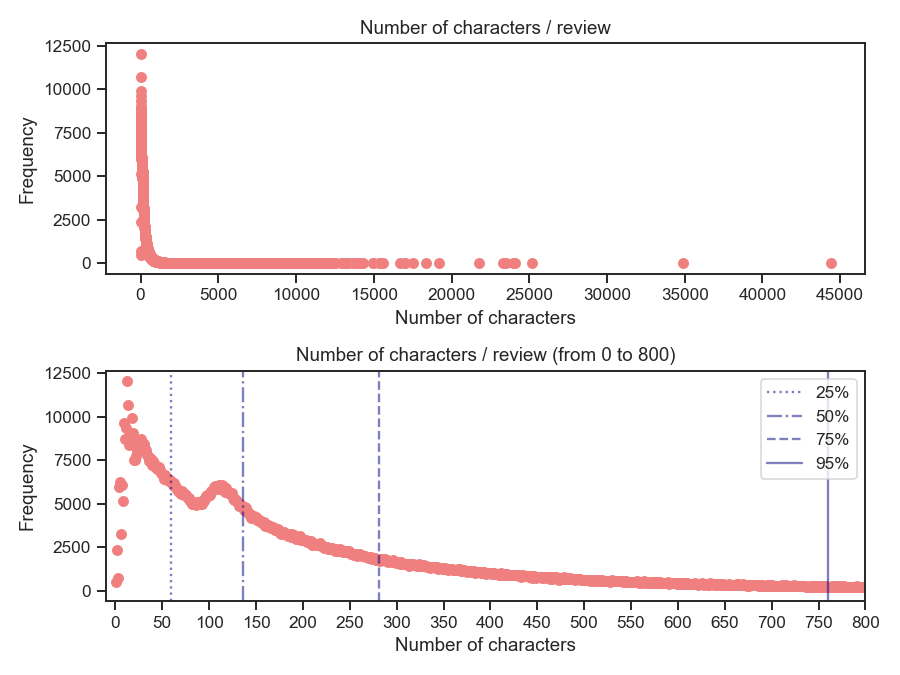

In [26]:
# Create a count plot
length_counter = Counter(review_length)

plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.scatter(length_counter.keys(), length_counter.values(), c='lightcoral')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 45000 + 1, 5000))
plt.title('Number of characters / review')

plt.subplot(2,1,2)
plt.scatter(length_counter.keys(), length_counter.values(), c='lightcoral')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.xlim([-10,800])
plt.xticks(np.arange(0, 800 + 1, 50))
plt.axvline(x=59, ymin=0, ymax=12500, c='navy', alpha=0.5, label='25%', ls=':')
plt.axvline(x=136, ymin=0, ymax=12500, c='navy', alpha=0.5, label='50%', ls='-.')
plt.axvline(x=281, ymin=0, ymax=12500, c='navy', alpha=0.5, label='75%', ls='--')
plt.axvline(x=760, ymin=0, ymax=12500, c='navy', alpha=0.5, label='95%', ls='-')
plt.title('Number of characters / review (from 0 to 800)')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

95th percentile was 760 characters per review. I think 760 characters are enough to describe the products. Longer reviews will make the model complicated. Let's remove the longer reviews more than 760.

In [27]:
# Remove reviews longer than 760
df_less760_chara = df_drop_dup.query('review_body.str.len() <= 760')
len(df_less760_chara)

1612532

84,693 (1,697,225 - 1,612,532) reviews were removed.

In [28]:
# Check the reviews having only one character
df_less760_chara.query('review_body.str.len() == 1').head()

,product_id,product_title,review_body
1116,167929142,Littermaid Receptacles,f
2080,230993905,RFA-188 3-Volt Lithium Battery,k
2090,698234953,Instinct Grain Free All Natural Oven-Baked Bis...,1
3905,264157737,Nutramax Denamarin Supplemental Tablets,K
4407,350664549,PetSafe 6-Volt Lithium Battery (2 Batteries pe...,😀


In [29]:
# Check the reviews having two character
df_less760_chara.query('review_body.str.len() == 2').head()

,product_id,product_title,review_body
275,694724594,Tetra 77035 TetraFin Floating Variety Pellets,OK
2178,58740630,Giant Mealworms - Jumbo Mealworms for Feeding ...,:/
3837,78582590,Wahl Pet Clipper Hair Cutting Kit for touch up...,ok
4519,852092603,Yescom Aquarium Internal Filter 3in1 80GPH 300...,Ok
5002,666431592,Petvi all natural probiotic nutritional supple...,ok


In [30]:
# The number of the products removed
df_drop_dup['product_id'].nunique() - df_less760_chara['product_id'].nunique()

2210

2,210 products are 1.7% of the total.

Short reviews might not have enough information to characterize the product. I am removing reviews having fewer than 30 characters.

In [31]:
# Remove reviews having fewer than 30 characters
df_more30_chara = df_less760_chara.query('review_body.str.len() >= 30')
len(df_more30_chara)

1396300

216,232 (1,612,532 - 1,396,300) reviews were removed.

In [32]:
# The number of the products removed
df_less760_chara['product_id'].nunique() - df_more30_chara['product_id'].nunique()

9967

9,967 products is 7.7% of the total.
I am going to show the products removed as a table.

In [33]:
# Extrct the products' names
products_more30_chara = df_more30_chara[['product_id', 'product_title']].drop_duplicates()
short_reviews = products_dropna[~products_dropna['product_id'].isin(products_more30_chara['product_id'])]

# Set the index to 'product_id' column
short_reviews = short_reviews.set_index(['product_id']).sort_index()

# Save the list to a csv file
#short_reviews.to_csv(short_review_products_list)

# Show the list
short_reviews

,product_title
product_id,
13903,Mr Bites 9-Inch Rawhide Retriever Roll for Dog...
114505,"1000 Live Superworms-Reptile, Birds, Fishing B..."
125740,"JurassiDiet - Newt & Frog, 120 g / 4.2 oz."
210582,Marineland C-Series C-160 & C-220 Canister Fil...
320416,Pet Champion 1.25-Inch Cushion Herringbone Dog...
...,...
999682628,Tampa Bay Lightning Pet Dog Pink Performance T...
999703990,San Francisco Bay Brand ASF71120 Freeze Dried ...
999759324,Hartz Delectables Gourmet Treats for Cats Roas...


Table2. Short and long review products list

The number of the removed products should be 12,177, but 12,190.

In [34]:
# Check the number of products in short_reviews
short_reviews.index.nunique()

12177

The differenct was caused by some products having two different product titles.

In [35]:
# Show the number of reviews in df_more30_chara
len(df_more30_chara)

1396300

In [36]:
# Show the number of products in df_more30_chara
df_more30_chara['product_id'].nunique()

116800

Now, there are 1,396,300 observations (reviews) and 116,800 products. 

### 2.5. Removing products having only one review

I have decided to remove products having only one review because it would be difficult to find common words with other products by using the only one review, also one review would mean not so active as a product.

In [37]:
# Recheck df_drop_dup
df_more30_chara.head()

,product_id,product_title,review_body
0,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Best belly bands on the market! These are a g...
1,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,"My dogs love Hugs and Kisses. However, the la..."
2,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,I have been purchasing these for a long time. ...
3,568880110,"Soft Side Pet Crate, Navy/Tan","It is extremely well constructed, it is easy t..."
4,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Worked really well. Very pleased with my purc...


In [38]:
# Group by 'product_id' and count the number of reviews for each product
df_count_by_product = df_more30_chara[['product_id', 'review_body']].groupby('product_id').count()

# Change the column label
df_count_by_product.columns = ['number_of_reviews']

In [39]:
df_count_by_product.describe()

,number_of_reviews
count,116800.000000
mean,11.954623
std,62.215982
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,4285.000000


In [40]:
# 95 percentile
df_count_by_product.quantile(0.95)

number_of_reviews    42.0
Name: 0.95, dtype: float64

<IPython.core.display.Javascript object>


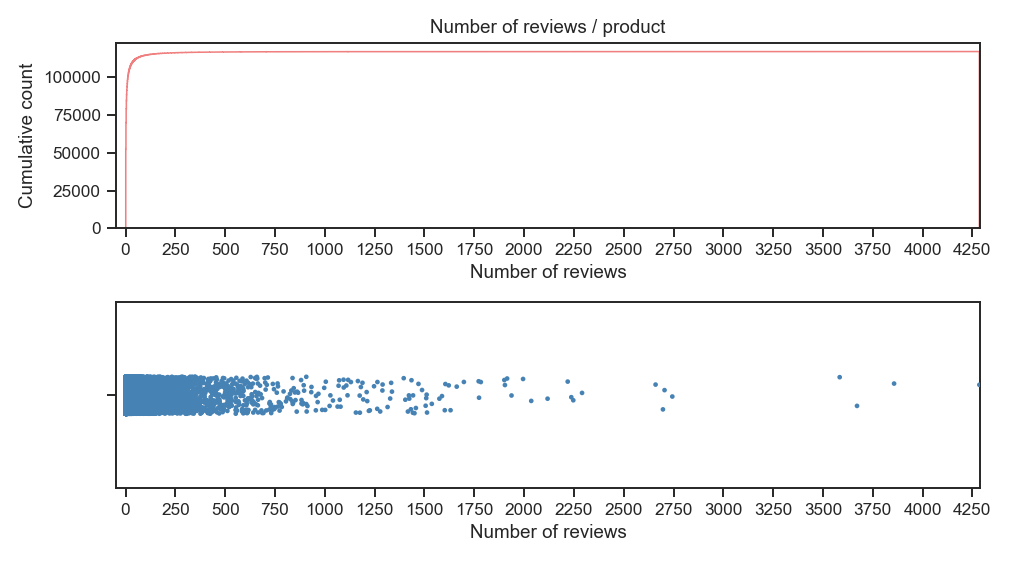

In [41]:
# Draw a strip plot and a count plot
plt.figure(figsize=(9,5))

plt.subplot(2,1,1)
plt.hist(df_count_by_product['number_of_reviews'], bins=4285, cumulative=True, histtype='step', color='lightcoral')
plt.xlim([-50,4290])
plt.xticks(range(0,4300,250))
plt.xlabel('Number of reviews')
plt.ylabel('Cumulative count')
plt.title('Number of reviews / product')

plt.subplot(2,1,2)
sns.stripplot(x='number_of_reviews', data=df_count_by_product, size=3, color='steelblue', jitter=True)
plt.xlim([-50,4290])
plt.xticks(range(0,4300,250))
plt.xlabel('Number of reviews')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


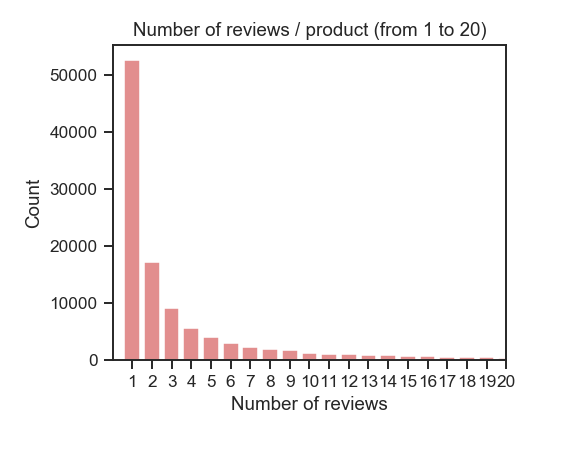

In [42]:
# Draw a strip plot and a count plot
plt.figure(figsize=(5,4))

sns.countplot(x='number_of_reviews', data=df_count_by_product, color='lightcoral')
plt.xlim([-1,19])
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.title('Number of reviews / product (from 1 to 20)')

plt.subplots_adjust(left=0.2, right=0.90, bottom=0.2, top=0.90)
plt.show()

There are many products having only one review.

In [43]:
# Count of the number of products having only one review
df_count_1 = df_count_by_product[df_count_by_product['number_of_reviews'] <= 1]
len(df_count_1)

52647

In [44]:
# Set the index to 'product_id' to drop rows by index, and drop rows which products have one review
df_more1 = df_more30_chara.set_index(['product_id']).sort_index().drop(df_count_1.index)
df_more1.head()

,product_title,review_body
product_id,,
3270,PETSOO Puppy Dog Pets Cute Winter Clothing Coa...,Ordered an xs and got a small. So obviously it...
3270,PETSOO Puppy Dog Pets Cute Winter Clothing Coa...,Very soft warm material . Very large for a 3 p...
3270,PETSOO Puppy Dog Pets Cute Winter Clothing Coa...,Best Coat a dog can have. Very well made
17464,"Beastie Bands ZEBRA Cat Collar, Stripes",This Beastie Band collar was a good buy. It w...
17464,"Beastie Bands ZEBRA Cat Collar, Stripes","Safe, looks great, easily adjustable, affordab..."


In [45]:
# Check the distribution after removing reviews having one review
df_count_more1 = df_count_by_product[df_count_by_product['number_of_reviews'] > 1]
df_count_more1.describe()

,number_of_reviews
count,64153.000000
mean,20.944508
std,82.874375
min,2.000000
25%,2.000000
50%,5.000000
75%,13.000000
max,4285.000000


Products having only one review were removed.  
The products are shown as a list for later.

In [46]:
# Extrct the products' names
# products_more30_chara = df_more30_chara[['product_id', 'product_title']].drop_duplicates()
one_review = products_more30_chara[~products_more30_chara['product_id'].isin(df_more1.index)] 

# Set the index to 'product_id' column
one_review = one_review.set_index(['product_id']).sort_index()

# Save the list to a csv file
#one_review.to_csv(one_review_products_list)

# Show the list
one_review

,product_title
product_id,
8072,YML Lot of 12 Clear Plastic Cup for Breeding C...
53358,Ivermectin Sheep Drench 8 oz.
72022,Up Country Anchors Aweigh Design - Size Medium...
97110,Bio spot 100504718 Bio Spot Defense Flea & Tic...
98023,Darford Omega Booster Salmon and Mackeral 20 U...
...,...
999914469,Large Cat Play Tree
999930748,"New Earth Soy Adjustable Collar, 1"""
999931715,Hand Puppet Dog Toy--ALLIGATOR


Table3. One review products list

### 2.6. Adjusting the number of reviews per product

The number of reviews per product is adjusted to be two to five to make this model efficient.

In [47]:
# Count the number of products having equal to or greater than 6 reviews
df_count_more5 = df_count_by_product[df_count_by_product['number_of_reviews'] >= 6]
len(df_count_more5)

28350

In [48]:
# Extract rows which products have 2 to 5 reviews
df_2to5 = df_more1.drop(df_count_more5.index)
df_2to5.head()

,product_title,review_body
product_id,,
3270,PETSOO Puppy Dog Pets Cute Winter Clothing Coa...,Ordered an xs and got a small. So obviously it...
3270,PETSOO Puppy Dog Pets Cute Winter Clothing Coa...,Very soft warm material . Very large for a 3 p...
3270,PETSOO Puppy Dog Pets Cute Winter Clothing Coa...,Best Coat a dog can have. Very well made
19343,PetSafe PIF00-12917 Stay & Play Wireless Fence,"Works very well, rechargeable collar is a big ..."
19343,PetSafe PIF00-12917 Stay & Play Wireless Fence,I bought one of these about 2 months ago. I th...


In [49]:
# Get the rows which products have equal to or greater than 6 reviews 
df_more5 = df_more1[~df_more1.index.isin(df_2to5.index)]
df_more5.head(10)

,product_title,review_body
product_id,,
17464,"Beastie Bands ZEBRA Cat Collar, Stripes",This Beastie Band collar was a good buy. It w...
17464,"Beastie Bands ZEBRA Cat Collar, Stripes","Safe, looks great, easily adjustable, affordab..."
17464,"Beastie Bands ZEBRA Cat Collar, Stripes",I LOVE these bands for convenience sake. Velc...
17464,"Beastie Bands ZEBRA Cat Collar, Stripes",After losing several collars during her outdoo...
17464,"Beastie Bands ZEBRA Cat Collar, Stripes","Perfect cat collar, have these on all my cats...."
17464,"Beastie Bands ZEBRA Cat Collar, Stripes",These have been great collars for my cats. St...
17464,"Beastie Bands ZEBRA Cat Collar, Stripes",These are really fabulous. I have a cat that ...
17464,"Beastie Bands ZEBRA Cat Collar, Stripes",I really like the Beastie Bands for my cats. ...
52493,Hartz Groomer's Best Pedicure Kit for Dogs and...,"First of all it wasn't even purple, it was ora..."


In [50]:
# Group by the index to get 5 reviews per product
df_more5_by_product = df_more5.groupby(level=0)

# Get 5 reviews per product
df_5_reviews = pd.DataFrame()
for product, group in df_more5_by_product:
    df_5_reviews = df_5_reviews.append(group.iloc[:5])
df_5_reviews.head(11)

,product_title,review_body
product_id,,
17464,"Beastie Bands ZEBRA Cat Collar, Stripes",This Beastie Band collar was a good buy. It w...
17464,"Beastie Bands ZEBRA Cat Collar, Stripes","Safe, looks great, easily adjustable, affordab..."
17464,"Beastie Bands ZEBRA Cat Collar, Stripes",I LOVE these bands for convenience sake. Velc...
17464,"Beastie Bands ZEBRA Cat Collar, Stripes",After losing several collars during her outdoo...
17464,"Beastie Bands ZEBRA Cat Collar, Stripes","Perfect cat collar, have these on all my cats...."
52493,Hartz Groomer's Best Pedicure Kit for Dogs and...,"First of all it wasn't even purple, it was ora..."
52493,Hartz Groomer's Best Pedicure Kit for Dogs and...,didn't care for the quality of these they are ...
52493,Hartz Groomer's Best Pedicure Kit for Dogs and...,These are better then our old nail clippers. ...
52493,Hartz Groomer's Best Pedicure Kit for Dogs and...,"Not at all what I wanted. Made it work, more f..."


In [51]:
# Merge the two dataframes
df_reduced_reviews = df_2to5.append(df_5_reviews)
df_reduced_reviews = df_reduced_reviews.reset_index()
df_reduced_reviews.head()

,product_id,product_title,review_body
0,3270,PETSOO Puppy Dog Pets Cute Winter Clothing Coa...,Ordered an xs and got a small. So obviously it...
1,3270,PETSOO Puppy Dog Pets Cute Winter Clothing Coa...,Very soft warm material . Very large for a 3 p...
2,3270,PETSOO Puppy Dog Pets Cute Winter Clothing Coa...,Best Coat a dog can have. Very well made
3,19343,PetSafe PIF00-12917 Stay & Play Wireless Fence,"Works very well, rechargeable collar is a big ..."
4,19343,PetSafe PIF00-12917 Stay & Play Wireless Fence,I bought one of these about 2 months ago. I th...


In [52]:
# Group by 'product_id' and count the number of reviews for each product
df_count_by_product_reduced = df_reduced_reviews[['product_id','review_body']].groupby('product_id').count()

# Change the column label
df_count_by_product_reduced.columns = ['number_of_reviews']

# Check the distribution
df_count_by_product_reduced.describe()

,number_of_reviews
count,64153.000000
mean,3.827802
std,1.298547
min,2.000000
25%,2.000000
50%,5.000000
75%,5.000000
max,5.000000


<IPython.core.display.Javascript object>


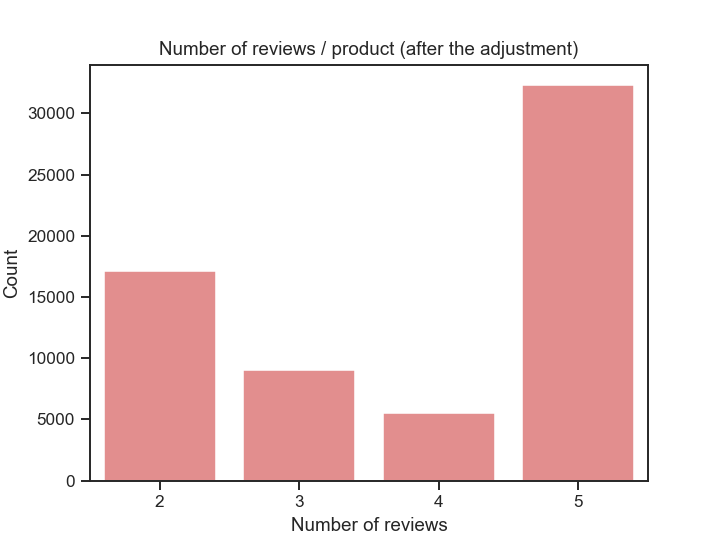

In [53]:
# Show a count plot
plt.figure()
sns.countplot(x='number_of_reviews', data=df_count_by_product_reduced, color='lightcoral')
plt.xlabel('Number of reviews')
plt.ylabel('Count')
plt.title('Number of reviews / product (after the adjustment)')
plt.show()

Now, all products have 2 to 5 reviews.

In [54]:
# Check the number of total reviews in df_reduced_reviews
len(df_reduced_reviews)

245565

In [55]:
# Check the number of products in df_reduced_reviews
df_reduced_reviews['product_id'].nunique()

64153

### 2.7. Merging reviews to the same product in one

In [56]:
# Merging reviews to the same product in one
df_by_product = df_reduced_reviews[['product_id', 'review_body']].groupby('product_id').sum()
df_by_product.head()

,review_body
product_id,
3270,Ordered an xs and got a small. So obviously it...
17464,This Beastie Band collar was a good buy. It w...
19343,"Works very well, rechargeable collar is a big ..."
23478,Worked great - Good sturdy heavy duty cage.<br...
52250,Smaller than it looks! Really disappointed.The...


In [57]:
# Make a 'product_id'-'product_title' table for later
id_name = df_reduced_reviews[['product_id', 'product_title']].groupby('product_id').sum()
id_name

,product_title
product_id,
3270,PETSOO Puppy Dog Pets Cute Winter Clothing Coa...
17464,"Beastie Bands ZEBRA Cat Collar, StripesBeastie..."
19343,PetSafe PIF00-12917 Stay & Play Wireless Fence...
23478,YML Double Door Dog Kennel Cage with Plastic T...
52250,Living World Outdoor Bird FeederLiving World O...
...,...
999930798,"S3 Granules For Dogs, 960 GramsS3 Granules For..."
999944581,"KONG ZoomGroom, Dog Grooming Brush, SmallKONG ..."
999961811,Tradewinds 8785 Canine Tapeworm Tablets - 5 x ...


Table4. 'Product_id'-'product_title' table

### 2.8. Tokenization

In [58]:
# Make a list of reviews
reviews_list = list(df_by_product['review_body'])
reviews_list[:2]

['Ordered an xs and got a small. So obviously it is too big. Very cute though. Disappointed.Very soft warm material . Very large for a 3 pounds dog . Good lenght but to large . It fits my other dog maltesse - 9.5 pounds. It tooks very long time to arrive.... almost a month . One button came out alreadyBest Coat a dog can have. Very well made',
 "This Beastie Band collar was a good buy.  It was easy to fit and works great.Safe, looks great, easily adjustable, affordable...I LOVE these bands for convenience sake.  Velcro is the easiest way to get a collar on a skittish cat.<br /><br />HOWEVER... my cat just chews right through the material itself.  So, If you have a cat that is ok with these collars, they are GREAT... If not... You will find them on the floor. At least nylon collars are hard to chew through (again, a pro AND a con as these will stretch and rip off if caught up on something).After losing several collars during her outdoor forays, our cat, Frences, can't lose this collar. 

In [59]:
# Tokenize the reviews
tokens_list = [nltk.word_tokenize(review) for review in reviews_list] 
tokens_list[1][:5]

['This', 'Beastie', 'Band', 'collar', 'was']

In [60]:
# Count the number of each word 
words_list_before = [token for review in tokens_list for token in review]
frequency_before = nltk.FreqDist(words_list_before)

# Sort the dictionary
frequency_before_sorted = dict(sorted(frequency_before.items(), key=lambda w: w[1]))

<IPython.core.display.Javascript object>


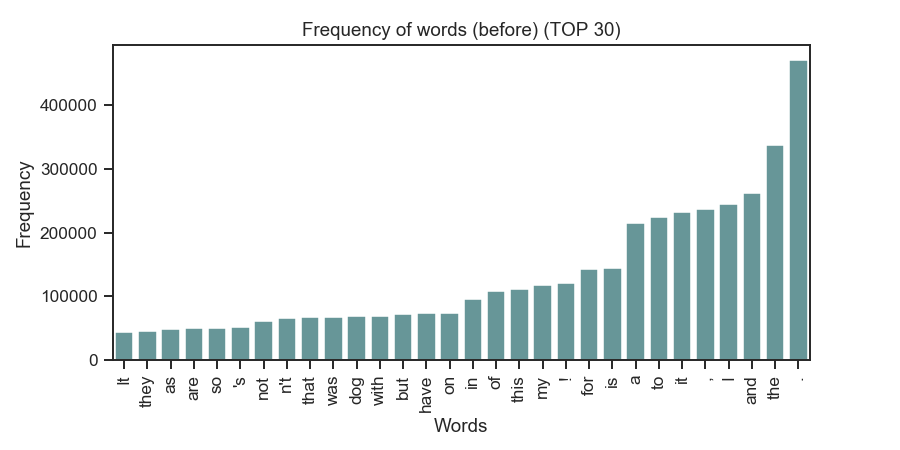

In [61]:
# Create a plot
plt.figure(figsize=(8,4))
sns.barplot(x=list(frequency_before_sorted.keys())[-30:], y=list(frequency_before_sorted.values())[-30:], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (before) (TOP 30)')
plt.subplots_adjust(left=0.125, right=0.90, bottom=0.2, top=0.90)
plt.show()

There are many words that would not be useful to the model. I'm cleaning up the words.

In [62]:
# How many unique words?
before_word_number = len(set(token for review in tokens_list for token in review))
before_word_number

185716

In [63]:
# lower case
tokens_lower_list = [[token.lower() for token in review] for review in tokens_list]
tokens_lower_list[0][:10]

['ordered', 'an', 'xs', 'and', 'got', 'a', 'small', '.', 'so', 'obviously']

In [64]:
# How many kinds of words were removed?
lower_word_number = len(set(token for review in tokens_lower_list for token in review))
before_word_number - lower_word_number

26617

### 2.9. Retaining only alphabets 

In [65]:
# Retain alphabetic words
tokens_alpha_list = [[token for token in review if token.isalpha()] for review in tokens_lower_list]
tokens_alpha_list[0][:10]

['ordered', 'an', 'xs', 'and', 'got', 'a', 'small', 'so', 'obviously', 'it']

In [66]:
# How many kinds of words were removed?
alph_word_number = len(set(token for review in tokens_alpha_list for token in review))
lower_word_number - alph_word_number

90811

### 2.10. Removing stop words

In [67]:
# Remove all stop words
cached_stop_words = stopwords.words('english')
tokens_nostop_list = [[token for token in review if token not in cached_stop_words] for review in tokens_alpha_list]
tokens_nostop_list[0][:10]

['ordered',
 'xs',
 'got',
 'small',
 'obviously',
 'big',
 'cute',
 'though',
 'soft',
 'warm']

In [68]:
# How many kinds of words were removed?
nostop_word_number = len(set(token for review in tokens_nostop_list for token in review))
alph_word_number - nostop_word_number

147

In [69]:
# Show the number of unique words
nostop_word_number

68141

### 2.11. Stemming and lemmatization

In [70]:
# Stemming by Snowball stemmer
snowball = SnowballStemmer(language='english')

tokens_stem_list = [[snowball.stem(token) for token in review] for review in tokens_nostop_list]
tokens_stem_list[0][:10]

['order',
 'xs',
 'got',
 'small',
 'obvious',
 'big',
 'cute',
 'though',
 'soft',
 'warm']

In [71]:
# How many kinds of words were removed?
stem_word_number = len(set(token for review in tokens_stem_list for token in review))
nostop_word_number - stem_word_number

17525

In [72]:
# Lemmatization to tokens_stem_list
lem = nltk.WordNetLemmatizer()

tokens_lem_list = [[lem.lemmatize(token) for token in review] for review in tokens_stem_list]
tokens_lem_list[0][:10]

['order',
 'x',
 'got',
 'small',
 'obvious',
 'big',
 'cute',
 'though',
 'soft',
 'warm']

In [73]:
# How many kinds of words were removed?
stem_lem_word_number = len(set(token for review in tokens_lem_list for token in review))
stem_word_number - stem_lem_word_number

223

In [74]:
# Show the number of unique words
stem_lem_word_number

50393

### 2.12. Retaining only nouns

In [75]:
# Show POS
tag_list = [nltk.pos_tag(review) for review in tokens_stem_list]
tag_list[0][:10]

[('order', 'NN'),
 ('xs', 'NNP'),
 ('got', 'VBD'),
 ('small', 'JJ'),
 ('obvious', 'JJ'),
 ('big', 'JJ'),
 ('cute', 'NN'),
 ('though', 'IN'),
 ('soft', 'JJ'),
 ('warm', 'JJ')]

In [76]:
# Retain only nouns
token_noun_list = [[token[0] for token in review if token[1] == ('NN' or 'NNP' or 'NNPS' or 'NNS' or 'VBG')] for review in tag_list]
token_noun_list[0][:10]

['order',
 'cute',
 'materi',
 'larg',
 'pound',
 'lenght',
 'larg',
 'fit',
 'dog',
 'maltess']

In [77]:
# How many kinds of words were removed?
noun_word_number = len(set(token for review in token_noun_list for token in review))
stem_word_number - noun_word_number

14375

In [78]:
# Show the number of unique words
noun_word_number

36241

### 2.13. Removing words appearing 4 times or less

Words appearing only a few are not useful to know the relationship with other products. I'm removing the words.

In [79]:
# Count the number of each word in the documents
# Put all words in a list
words_list_noun = [token for review in token_noun_list for token in review]

frequency_noun = nltk.FreqDist(words_list_noun)

In [80]:
# Collect words appearing 4 times or less
words_few = [k for k,v in frequency_noun.items() if v <= 4]

# How many words appearing 4 times or less?
print(len(words_few))

# Show the words
words_few[:10]

27051


['maltess',
 'foray',
 'frenc',
 'clksure',
 'overlay',
 'cheepli',
 'derang',
 'ovr',
 'thanksdog',
 'healthyit']

In [81]:
# Remove words appearing 4 times or less
token_more4_list = [[token for token in review if token not in words_few] for review in  token_noun_list]

In [82]:
# Show the number of unique words
len(set(token for review in token_more4_list for token in review))

9190

In [83]:
# Count the number of each word 
words_list_more4 = [token for review in token_more4_list for token in review]
frequency_more4 = nltk.FreqDist(words_list_more4)

# Sort the dictionary
frequency_more4_sorted = dict(sorted(frequency_more4.items(), key=lambda w: w[1]))

<IPython.core.display.Javascript object>


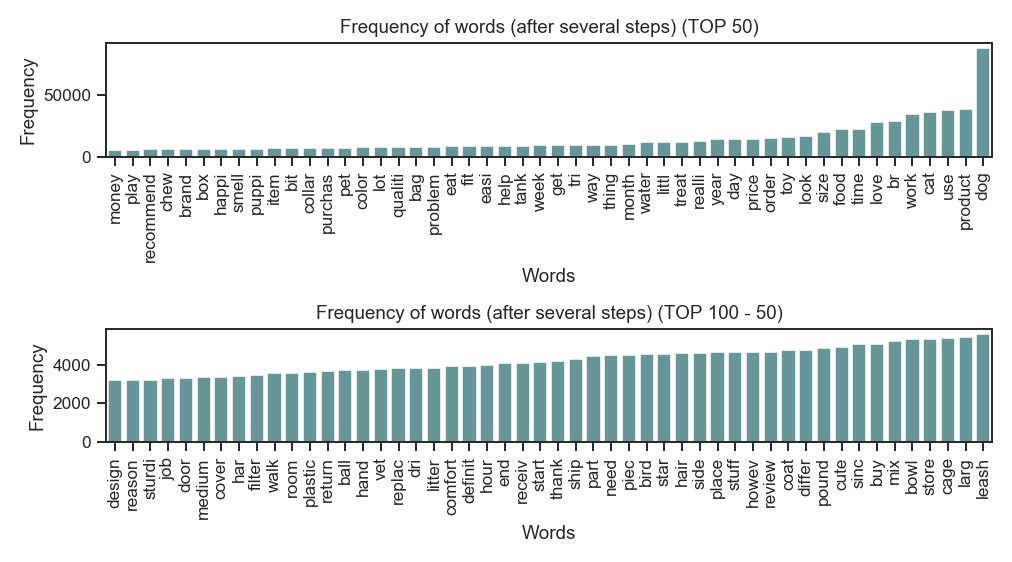

In [84]:
# Create a plot
plt.figure(figsize=(9,5))
plt.subplot(2,1,1)
sns.barplot(x=list(frequency_more4_sorted.keys())[-50:], y=list(frequency_more4_sorted.values())[-50:], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after several steps) (TOP 50)')

plt.subplot(2,1,2)
sns.barplot(x=list(frequency_more4_sorted.keys())[-100:-50], y=list(frequency_more4_sorted.values())[-100:-50], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after several steps) (TOP 100 - 50)')

plt.tight_layout()
plt.show()

Some words on this chart would not be usable.  I'm removing the words by hand.

In [85]:
# Collect words that would not be useful to categolize products from TOP 100 words
removed_words = ['br', 'product', 'work', 'love', 'time', 'look', 'day', 'year', 'order', 'price', 'realli', 'littl', 'thing', 'month',
                 'thing', 'tri', 'way', 'week', 'get', 'problem', 'help', 'easi', 'lot', 'purchas', 'bit', 'review', 'happi', 
                 'recommend', 'store', 'money', 'mix', 'differ', 'star', 'howev', 'buy', 'pound', 'review', 'end', 'need', 'start', 
                 'cute', 'piec', 'part', 'receiv', 'job', 'hour', 'ship', 'thank', 'replac', 'definit', 'return', 'reason']

# Remove them from token_more4_list
token_removed_list = [[token for token in review if token not in removed_words] for review in  token_more4_list]

In [86]:
# Count the number of each word 
words_list_after = [token for review in token_removed_list for token in review]
frequency_after = nltk.FreqDist(words_list_after)

# Sort the dictionary
frequency_after_sorted = dict(sorted(frequency_after.items(), key=lambda w: w[1]))

<IPython.core.display.Javascript object>


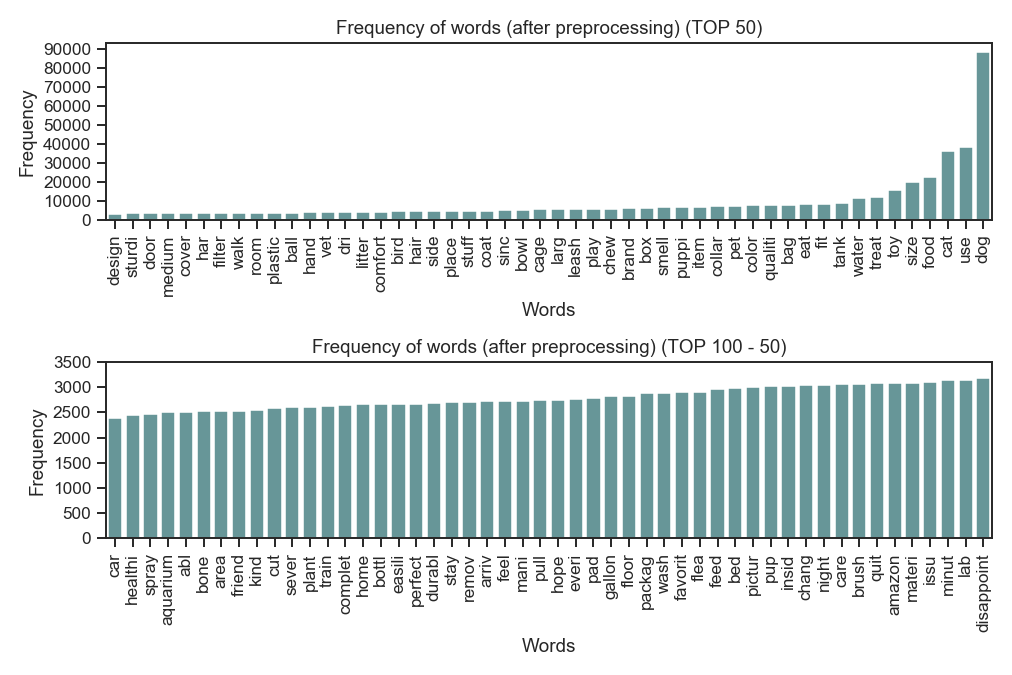

In [87]:
# Create a plot
plt.figure(figsize=(9,6))
plt.subplot(2,1,1)
sns.barplot(x=list(frequency_after_sorted.keys())[-50:], y=list(frequency_after_sorted.values())[-50:], color='cadetblue')
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 90000 + 1, 10000))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after preprocessing) (TOP 50)')

plt.subplot(2,1,2)
sns.barplot(x=list(frequency_after_sorted.keys())[-100:-50], y=list(frequency_after_sorted.values())[-100:-50],
            color='cadetblue')
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 3500 + 1, 500))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after preprocessing) (TOP 100 - 50)')

plt.tight_layout()
plt.show()

In [88]:
# Check the number of unique words
len(set(token for review in token_removed_list for token in review))

9140

In [89]:
# Confirm the number of products
len(token_removed_list)

64153

This is not changed.

### 2.14. Removing products having 4 tokens or less

In [90]:
# Check the number of tokens per product
number_token_list = [len(tokens) for tokens in token_removed_list]

In [91]:
# Show the minimum and maximum
min(number_token_list), max(number_token_list)

(0, 119)

In [92]:
# Check the number of products having 4 or less tokens
number_token_list.count(0), number_token_list.count(1), number_token_list.count(2), number_token_list.count(3), number_token_list.count(4)

(45, 182, 439, 725, 966)

In [93]:
# Remove the products having 4 or less tokens
token_moretokens_list = [token_removed_list[i] for i in range(len(token_removed_list)) 
                         if len(token_removed_list[i]) not in [0,1,2,3,4]]

# Show the number of the products in token_moretokens_list
len(token_moretokens_list)

61796

In [94]:
# Save token_moretokens_list as a csv file
# with open('token_list_2_5.csv', 'w', encoding='UTF-8') as f:
#     writer = csv.writer(f, lineterminator='\n')
#     writer.writerows(token_moretokens_list)

In [95]:
# Check the number of tokens per product
number_token_removed_list = [len(tokens) for tokens in token_moretokens_list]

# Show the minimum and maximum
min(number_token_removed_list), max(number_token_removed_list)

(5, 119)

<IPython.core.display.Javascript object>


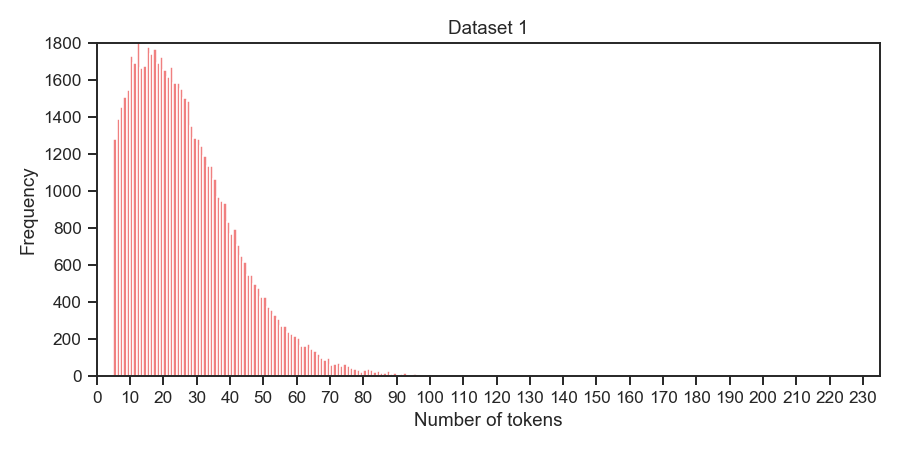

In [96]:
# Draw a cumulative count plot
plt.figure(figsize=(8,4))

plt.hist(number_token_removed_list, bins=114, color='lightcoral')
plt.xlim([0,235])
plt.xticks(range(0,235,10))
plt.ylim([0,1800])
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.title('Dataset 1') 

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


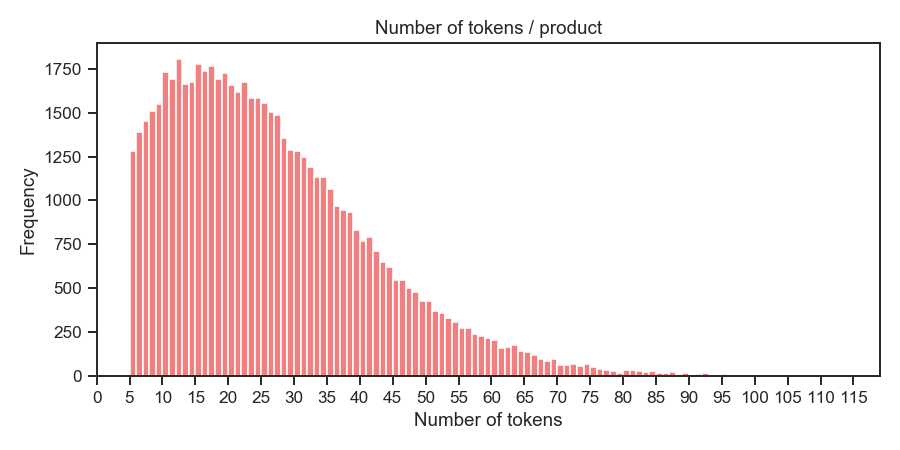

In [97]:
# Draw a cumulative count plot
plt.figure(figsize=(8,4))

plt.hist(number_token_removed_list, bins=114, color='lightcoral')
plt.xlim([0,119])
plt.xticks(range(0,120,5))
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.title('Number of tokens / product') 

plt.tight_layout()
plt.show()

In [98]:
# Calculate the 90 percentiles
np.percentile(number_token_removed_list, [25, 50, 75, 90])

array([14., 23., 35., 48.])

In [99]:
# Calculate the mean
np.mean(number_token_removed_list)

26.300213606058644

In [100]:
# Calculate the std
np.std(number_token_list)

15.869182581235577

90 % of products have 5 to 48 reviews. The mean was 26.3.

I am making a new id_name table.

In [101]:
# Get the indexes which products have a few tokens
few_tokens_index_list = [i for i in range(len(token_removed_list)) if len(token_removed_list[i]) in [0,1,2,3,4]]
few_tokens_index_list[:5], len(few_tokens_index_list)

([4, 22, 26, 45, 118], 2357)

In [102]:
# Get product_ids of the products removed
fewtoken_product_id = [id_name.index[i] for i in few_tokens_index_list]
fewtoken_product_id[:5]

[52250, 348435, 429796, 787466, 1989369]

In [103]:
# Make a new id-name list
new_id_name = id_name.drop(fewtoken_product_id).groupby(level=0).sum()

# Save the list to a csv file
#new_id_name.to_csv(product_id_name_list)

# Show the list
new_id_name

,product_title
product_id,
3270,PETSOO Puppy Dog Pets Cute Winter Clothing Coa...
17464,"Beastie Bands ZEBRA Cat Collar, StripesBeastie..."
19343,PetSafe PIF00-12917 Stay & Play Wireless Fence...
23478,YML Double Door Dog Kennel Cage with Plastic T...
52493,Hartz Groomer's Best Pedicure Kit for Dogs and...
...,...
999879135,EzyDog Micro Doggy Flotation Device (DFD)EzyDo...
999917918,Farnam Horse Health Electrolytes SupplementFar...
999944581,"KONG ZoomGroom, Dog Grooming Brush, SmallKONG ..."


Table4. Product id - name list (for the model)

In [104]:
# Save Product id-name list as a csv file
# new_id_name.to_csv('product_list_2_5.csv')

I am making a table for the products removed.

In [105]:
# Create a table of the removed product for later
fewtoken_products = id_name[~id_name.index.isin(new_id_name.index)]

# Save the list to a csv file
#fewtoken_products.to_csv(few_tokens_products_list)

# Show the list
fewtoken_products

,product_title
product_id,
52250,Living World Outdoor Bird FeederLiving World O...
348435,Funmate Cichlid Fish Breeding Egg Incubate Tum...
429796,"Small Blue Checkered Dog Harness 9""D Neck, 11...."
787466,Crazycity Water Nipple Drinker Chicken Feeder ...
1989369,20 lb Lite Propane Cylinder20 lb Lite Propane ...
...,...
997780311,3 Pieces 4 inches Long Natural Cholla Wood for...
998578905,MOMMY'S BOY ★ Pet Dog Shirt Embroidered ★ All ...
999053564,Charming Tails Nestled In Autumn's BeautyCharm...


Table5. Few tokens products list

## 3. Exploratory Data Analysis

3.1. The number of products relating to each animal kind  
3.2. The number of products relating to each application type  
3.3. The rough relationship between an animal kind and application type

### 3.1. The number of products relating to each animal kind

Count the rough numbers of products relating to a specific animal.

In [106]:
# Define a function returning the number of products having a specific word as a token
def count_word(word):
    count = 0
    for product in token_moretokens_list:
        if word in product:
            count += 1
    return count

In [107]:
# Count products having 'dog', 'puppi' or 'doggi' as a token
count_dog = count_word('dog')
count_puppi = count_word('puppi')
count_doggi = count_word('doggi')
count_dogs = count_dog + count_puppi + count_doggi
print('Dog:', count_dogs)

# Count products having 'cat', 'kitti', 'kitt' or 'kitten' as a token
count_cat = count_word('cat')
count_kitti = count_word('kitti')
count_kitt = count_word('kitt')
count_kitten = count_word('kitten')
count_cats = count_cat + count_kitti + count_kitt + count_kitten
print('Cat:', count_cats)

# Count products having 'bird' as a token
count_bird = count_word('bird')
count_chick = count_word('chick')
count_birds = count_bird + count_chick
print('Bird:', count_birds)

# Count products having 'fish' as a token
count_fish = count_word('fish')
print('Fish:', count_fish)

# Count products having 'rabit' as a token
count_rabbit = count_word('rabbit')
count_bunni = count_word('bunni')
count_rabbits = count_rabbit + count_bunni
print('Rabbit:', count_rabbits)

Dog: 39145
Cat: 12424
Bird: 2284
Fish: 1411
Rabbit: 1332


<IPython.core.display.Javascript object>


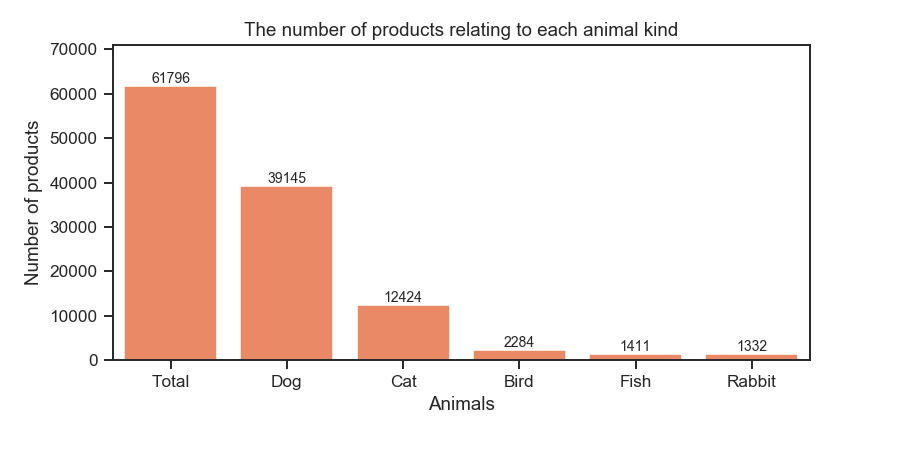

In [108]:
# Draw a bar plot
plt.figure(figsize=(8,4))

X = ['Total', 'Dog', 'Cat', 'Bird', 'Fish', 'Rabbit']
Y = [len(token_moretokens_list), count_dogs, count_cats, count_birds, count_fish, count_rabbits]

p = sns.barplot(x=X, y=Y, color='coral')
plt.xlabel('Animals')
plt.ylabel('Number of products')
plt.ylim([0, 71000])
plt.title('The number of products relating to each animal kind')

for x, y in zip([0, 1, 2, 3, 4, 5], Y):
    plt.text(x, y, y, ha='center', va='bottom', fontsize=9)

plt.subplots_adjust(left=0.125, right=0.90, bottom=0.2, top=0.90)
plt.show()

The main products were for dogs or cats.

### 3.2. The number of products relating to each application type

Count the rough numbers of products relating to food, treats, toys, toilet, cages, clothes, or collars.

In [109]:
# Count products having 'food', 'dri' or 'wet' as a token
count_food = count_word('food')
count_dri = count_word('dri')
count_wet = count_word('wet')
count_foods = count_food + count_dri + count_wet
print('Food:', count_foods)

# Count products having 'treat', 'snack', or 'cooki' as a token
count_treat = count_word('treat')
count_snack = count_word('snack')
count_cooki = count_word('cooki')
count_treats = count_treat + count_snack + count_cooki
print('Treat:', count_treats)

# Count products having 'toy', 'tunnel', 'ball', 'rope', or 'stuff' as a token
count_toy = count_word('toy')
count_tunnel = count_word('tunnel')
count_ball = count_word('ball')
count_rope = count_word('rope')
count_stuff = count_word('stuff')
count_toys = count_toy + count_tunnel + count_ball + count_rope + count_stuff
print('Toy:', count_toys)

# Count products having 'litter', or 'pad' as a token
count_litter = count_word('litter')
count_pad = count_word('pad')
count_toilet = count_litter + count_pad
print('Toilet:', count_toilet)

# Count products having 'cage', 'crate', 'carrier', or 'kennel' as a token
count_cage = count_word('cage')
count_crate = count_word('crate')
count_carrier = count_word('carrier')
count_kennel = count_word('kennel')
count_cages = count_cage + count_crate + count_carrier + count_kennel
print('Cage:', count_cages)

# Count products having 'shirt', 'coat', 'sweater', or 'costum' as a token
count_shirt = count_word('shirt')
count_coat = count_word('coat')
count_sweater = count_word('sweater')
count_costum = count_word('costum')
count_clothes = count_shirt + count_coat + count_sweater + count_costum
print('Clothes:', count_clothes)

# Count products having 'collar', or 'leash' as a token
count_collar = count_word('collar')
count_leash = count_word('leash')
count_collar_leash = count_collar + count_leash
print('Collar&Leash:', count_collar_leash)

Food: 12003
Treat: 6483
Toy: 12765
Toilet: 3029
Cage: 4088
Clothes: 4549
Collar&Leash: 6175


<IPython.core.display.Javascript object>


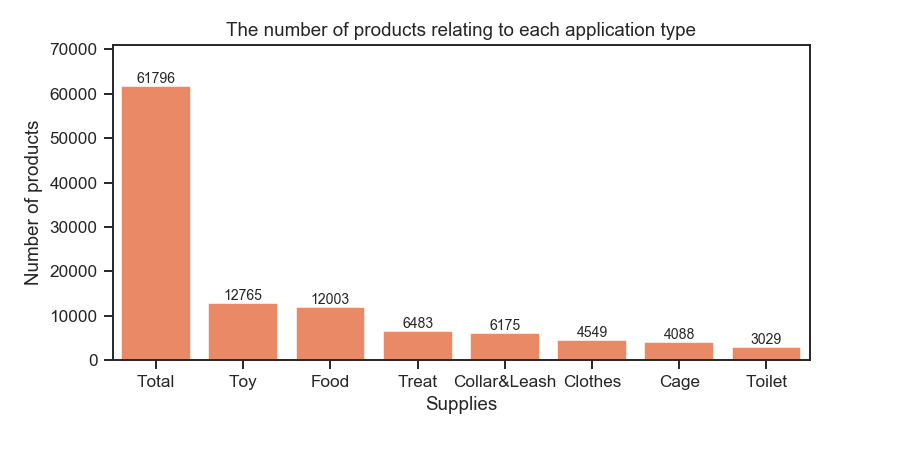

In [110]:
# Draw a bar plot
plt.figure(figsize=(8,4))

X2 = ['Total', 'Toy', 'Food', 'Treat', 'Collar&Leash', 'Clothes', 'Cage', 'Toilet']
Y2 = [len(token_moretokens_list), count_toys, count_foods, count_treats, count_collar_leash, count_clothes,count_cages, count_toilet]

sns.barplot(x=X2, y=Y2, color='coral')
plt.xlabel('Supplies')
plt.ylabel('Number of products')
plt.ylim([0, 71000])
plt.title('The number of products relating to each application type')

for x, y in zip([0, 1, 2, 3, 4, 5, 6, 7], Y2):
    plt.text(x, y, y, ha='center', va='bottom', fontsize=9)

plt.subplots_adjust(left=0.125, right=0.90, bottom=0.2, top=0.90)
plt.show()

The Top 2 categories are Food and Toy, but the products are relatively spread.

### 3.3. The rough relationship visualization between an animal kind and application type

I pick up Dog and Cat as animal kind categories, and Toy and Food as application type categories. Check the relationships between them.

In [111]:
# Define a function making coordinates. word1 and word2 can accept a list.
def make_coordinate(list_name, word1, word2, num):
    for i in range(len(token_moretokens_list)):
        product = token_moretokens_list[i]
        for token in product:
            if token in word1:
                list_name[i][num] += 1
                break
        for token in product:
            if token in word2:
                list_name[i][num] += 2
                break
    return list_name

In [112]:
# Make coorfinates showing the presence of words; dog and/or cat,and toy and/or food
# [1, 0] means the product has 'dog' and doesn't have 'cat', 'toy', or 'food' as the tokens
# [3, 2] means the product has 'dog', 'cat', and 'food' as the tokens

# Make an initial list
animal_supply = [[0, 0] for i in range(len(token_moretokens_list))]

# Make coorfinates
animal_supply = make_coordinate(animal_supply, ['dog','puppi','doggi'], ['cat','kitti','kitt','kitten'] , 0)
animal_supply = make_coordinate(animal_supply, ['toy','tunnel','ball','rope','stuff'], ['food','dri','wet'], 1)
animal_supply[30:35]

[[3, 2], [0, 0], [0, 0], [2, 0], [0, 0]]

<IPython.core.display.Javascript object>


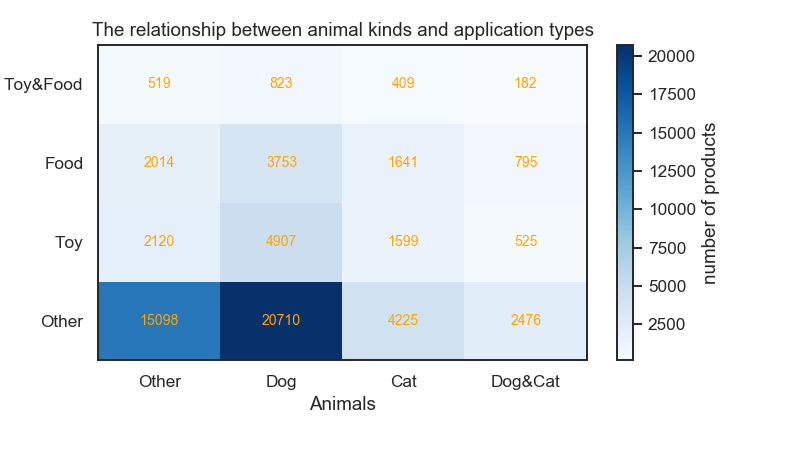

In [113]:
# Make an initial list to draw a pseudocolor plot
mesh_list = [[0,0,0,0], [0,0,0,0],[0,0,0,0],[0,0,0,0]]

# Count the number of products fitting each compartment and make the numpy array
for product in animal_supply:
    mesh_list[product[1]][product[0]] += 1
mesh_arr = np.array(mesh_list)

# Make mesh
u = np.linspace(-1, 1, 5)
v = np.linspace(-1, 1, 5)
X,Y = np.meshgrid(u, v)

# Draw a pseudocolor plot
plt.figure(figsize=(7,4))
plt.pcolor(mesh_arr, cmap='Blues')
pp = plt.colorbar()
pp.set_label('number of products')
plt.xticks(ticks=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], labels=['','Other', '', 'Dog', '', 'Cat', '', 'Dog&Cat', ''])
plt.yticks(ticks=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], labels=['','Other', '', 'Toy', '', 'Food', '', 'Toy&Food', ''])
plt.tick_params(bottom=False, left=False)
plt.xlabel('Animals')
plt.ylabel('Supplies')
plt.title('The relationship between animal kinds and application types')

for y in [0.5, 1.5, 2.5, 3.5]:
    for x in [0.5, 1.5, 2.5, 3.5]: 
        plt.text(x, y, mesh_list[int(y-0.5)][int(x-0.5)], ha='center', va='center', fontsize=9, color='orange')

plt.subplots_adjust(left=0.125, right=0.90, bottom=0.2, top=0.90)
plt.show()

Food and toys for dogs are the largest two categories on the chart, but many products are in Other. I will categorize them more precisely in the modeling part of this project. 

The modeling part is showed in a different jupyter notebook. See a jupyter notebook for modeling. 